In [10]:
import numpy as np
from scipy import ndimage as nd
import math
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [11]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = np.int(np.floor(r/factor))
    c = np.int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(gray,box)
    return image


# Pad image with zeros
def pad(image,factor):
    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Peak finding for nonmax supression
def peaks(image,window):
    factor = int(np.floor(window/2))
    image = pad(image,factor)
    peaks = np.zeros([image.shape[0],image.shape[1]])

    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            window = image[i-1:i+2,j-1:j+2]
            if image[i,j]==np.amax(window):
                peaks[i,j] = image[i,j]


    # remove padding
    peaks = peaks[factor:-factor,factor:-factor]

    return peaks


# Norm CC feature matching
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    add = np.int((filter.shape[0]-1)/2)
    padded = pad(image,add)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            if np.sum(np.sqrt(f**2))==0:
                norm_f = np.zeros([f.shape[0],f.shape[1]])
            else:
                norm_f = f/np.sqrt(np.sum(f**2))
            norm_g = filter/np.sqrt(np.sum(filter**2))

            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])

            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc

In [12]:
# Harris Corner Detector
def HarrisCorner(image,threshold):

    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    k = 0.05
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,3)

    return R


# Reduce threshold until ~1% of pixels are corners
def reducedHarris(image,ratio):
    threshold = 1.0
    while ratio >= 100:
        threshold = 0.1*threshold

        corners = HarrisCorner(image,threshold)
        # Number of corners
        idx = np.where(corners>0)
        idx = np.array(idx).T
        ratio = image.size/idx.shape[0]

    print('Threshold:',threshold)
    print('Corners:',idx.shape[0])

    return corners


# Improve corners from HCD
def neighboringCorner(corners,width,num_corners):
    # Remove isolated corners in a window

    good_corners = np.copy(corners)
    good_corners[good_corners>0] = 1
    good_corners[good_corners<0] = 0
    print('Previous corners:', np.sum(good_corners))

    filter = np.ones([width,width])
    neighbors = nd.convolve(good_corners,filter)

    neighbors[neighbors<num_corners] = 0
    neighbors[neighbors>=num_corners] = 1
    neighbors = neighbors*good_corners

    print('Better corners:',np.sum(neighbors))

    return corners*neighbors


# Find matches from im1 to im2
def findMatches(corners1,corners2,width,num_matches):
    
    matches = np.zeros([num_matches,4])
    i = 0
    while i<num_matches:
        # Get a random patch location
        idx = np.where(corners1>0)
        idx = np.array(idx).T
        rand_corner = np.random.randint(idx.shape[0],size=1)
        loc = idx[rand_corner,:]
        loc = np.concatenate(loc)
        r = loc[0]
        c = loc[1]

        # Patch from location
        left = np.int( (width-1)/2 )
        right = np.int( (width-1)/2 + 1 )
        patch = np.around(corners1[r-left:r+right,c-left:c+right])

        # Match the patch to second image
        fit = norm_cross_corr(corners2,patch)
        best = np.where(fit==np.amax(fit))
        best = np.array(best).T

        if best.shape[0] == 1:
            print("Match #",i+1)
            print(np.amax(fit))
            best = np.concatenate(best)
            matches[i,:] = np.array([r,c,best[0],best[1]])
            i+=1

    return matches


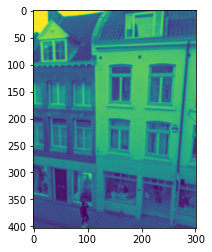

In [20]:
reduce = 10
blur = 3

# Load image1
file = 'street1.jpg'
image = Image.open(file)

# Reduce resolution
image = reduceRes(image,reduce)

# Convert to grayscale
gray = rgb2gray(image)

# Smooth image
im1 = boxFilter(gray,blur)
plt.imshow(im1)

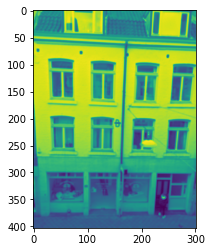

In [21]:
# Load image2
file = 'street2.jpg'
image = Image.open(file)

# Reduce resolution
image = reduceRes(image,reduce)

# Convert to grayscale
gray = rgb2gray(image)

# Smooth image
im2 = boxFilter(gray,blur)
plt.imshow(im2)

In [24]:
# Find sparse corners
print('Finding corners...')
ratio = 1000
corners1 = reducedHarris(im1,ratio)
corners2 = reducedHarris(im2,ratio)
print()

# Improve corners
print('Improving corners...')
width = 7
num_corners = 4
better_corners1 = neighboringCorner(corners1,width,num_corners)
better_corners2 = neighboringCorner(corners2,width,num_corners)

Finding corners...
Threshold: 0.00010000000000000003
Corners: 2134
Threshold: 0.00010000000000000003
Corners: 1672

Improving corners...
Previous corners: 2134.0
Better corners: 471.0
Previous corners: 1672.0
Better corners: 423.0


In [27]:
# Find matches
print('Finding matches...')
num_matches = 50
matches = findMatches(better_corners1,better_corners2,width,num_matches)

Finding matches...
Match # 1
0.9230026060175842
Match # 2
0.8742831006690804
Match # 3
0.9908890854495582
Match # 4
0.835241701651384
Match # 5
0.8903032956415269
Match # 6
0.8307799659457681
Match # 7
0.9121976259066306
Match # 8
0.9859732491515729
Match # 9
0.9950838993447088
Match # 10
0.8566922723440618
Match # 11
0.9011234996050332
Match # 12
0.9814658693439351
Match # 13
0.8641567547151325
Match # 14
0.9727036230341621
Match # 15
0.7078859840634935
Match # 16
0.9284878785883992
Match # 17
0.9479074850649435
Match # 18
0.8764726869970815
Match # 19
0.9991589641741593
Match # 20
0.9996873153116068
Match # 21
0.9817346798740632
Match # 22
0.9969177163840401
Match # 23
0.8765382997556788
Match # 24
0.990717321873343
Match # 25
0.9693638036336594
Match # 26
0.9293885353159969
Match # 27
0.9882716168597215
Match # 28
0.785564919736105
Match # 29
0.9756831349267252
Match # 30
0.9874550926051173
Match # 31
0.9121976259066306
Match # 32
0.9980902242967337
Match # 33
0.8791195753059381
Mat

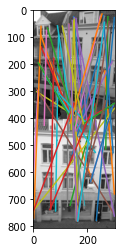

In [28]:
def drawLines(image1,image2,matches):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        plt.plot(y[i,:],x[i,:])
    
    return

drawLines(im1,im2,matches)